In [40]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
import matplotlib.pyplot as plt
from prettytable import PrettyTable

Visualization Pipeline

In [41]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [42]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers and time stamps
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
time_intervals = np.array(rp.get('timeStamps'))

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

In [43]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
time_intervals = time_intervals[0:2,:].T

# Slot spikes into cue phase intervals for each trial
spikecounts_per_trial = spike_counts_per_observation(time_intervals, spike_times)

# Normalize spike counts within each cell for visualization only
normalized_spikecounts_per_trial = np.empty_like(spikecounts_per_trial)
for col in range(spikecounts_per_trial.shape[1]):
    normalized_spikecounts_per_trial[:,col] = normalize_dataset(spikecounts_per_trial[:,col])

In [44]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

In [45]:
# Group spikes by goal
responses_per_goal = group_by_goal(spikecounts_per_trial, trial_markers)
normalized_responses_per_goal = group_by_goal(normalized_spikecounts_per_trial, trial_markers)

# Check number of responses per goal
num_responses_per_goal = np.array(list(map(lambda arr: arr.shape[0], responses_per_goal)))


In [46]:
def cosine_similarity(arr1: np.array, arr2: np.array) -> float:
    def magnitude(arr: np.array) -> float:
        return np.sqrt(np.dot(arr, arr))
    mag1, mag2 = magnitude(arr1), magnitude(arr2)
    if mag1 == 0 or mag2 == 0:
        return 0
    return np.dot(arr1, arr2) / (mag1 * mag2)

def pairwise_cosine_similarity(goal: np.array) -> float:
    scores = list()
    for i in range(goal.shape[0] - 1):
        obs1 = goal[i,:]
        for j in range(i+1, goal.shape[0]):
            obs2 = goal[j,:]
            scores.append(cosine_similarity(obs1, obs2))
    if len(scores) == 0:
        return 1
    return np.mean(scores)

def mean_response(goal: np.array) -> np.array:
    res = list()
    for cell in range(goal.shape[1]):
        obs = goal[:,cell]
        res.append(np.sum(obs) / obs.shape[0])
    return np.array(res)

def cross_cosine_similarity(goals: list) -> list:
    res = list()
    for goal in goals:
        goal_res = np.zeros(6)
        for num, comp in enumerate(goals):
            goal_res[num] = cosine_similarity(goal.flatten(), comp.flatten())
        res.append(goal_res)
    return res

In [47]:
# Compute metrics for each goal
goal_means, goal_sims = list(), list()
for goal in responses_per_goal:
    goal_means.append(mean_response(goal))
    goal_sims.append(pairwise_cosine_similarity(goal))

# Compute metrics across goals
cross_sims = cross_cosine_similarity(goal_means)

In [54]:
def plot_goal_response(num: int, goal_responses: np.array, goal_stats: float, savepath: str):
    plt.figure()
    plt.title(f'Goal #{num} responses - {day_dir}')
    pcm = plt.pcolormesh(goal_responses, cmap='viridis', vmin=0)
    plt.grid(linewidth=0.25)
    plt.xticks(np.arange(goal_responses.shape[1]), cell_labels, rotation=45)
    plt.yticks(np.arange(0, goal_responses.shape[0]+1, 10))
    plt.ylabel('Observations')
    plt.colorbar(pcm, label='Firing rate (95-percentile scaled)')
    goal_sim, cross_sim = goal_stats
    disp_table = list()
    for idx, score in enumerate(cross_sim):
        idx += 1
        if idx == num:
            disp_table.append(['self', f'{goal_sim:.3f}'])
        else:
            disp_table.append([f'{idx}', f'{score:.3f}'])
    plt.table(cellText=disp_table, colLabels=['Goal', 'Similarity'], cellLoc='center', colWidths=[0.15, 0.2], bbox=[1.3, 0.5, 0.4, 0.5])
    plt.savefig(f'{savepath}/goal{num}.png', bbox_inches='tight')
    plt.close()

In [55]:
# Plot responses for each goal
savepath = '/Users/jcheng/Documents/neural_decoding/20181102/goal_responses'
for num, goal in enumerate(normalized_responses_per_goal):
    goal_stats = (goal_sims[num], cross_sims[num])
    plot_goal_response(num+1, goal, goal_stats, savepath)

Individual Plots

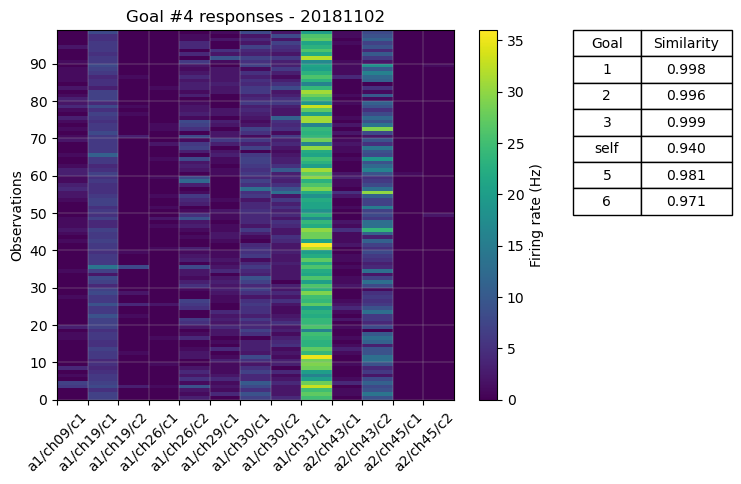

In [53]:
# Try plotting responses for one goal
goal = 3
goal_responses = responses_per_goal[goal]
goal_sim = goal_sims[goal]
cross_sim = cross_sims[goal]
disp_table = list()
for num, score in enumerate(cross_sim):
    if num == goal:
        disp_table.append(['self', f'{goal_sim:.3f}'])
    else:
        disp_table.append([f'{num+1}', f'{score:.3f}'])

plt.figure()
plt.title(f'Goal #{goal+1} responses - {day_dir}')
pcm = plt.pcolormesh(goal_responses, cmap='viridis', vmin=0)
plt.grid(linewidth=0.25)
plt.xticks(np.arange(goal_responses.shape[1]), cell_labels, rotation=45)
plt.yticks(np.arange(0, goal_responses.shape[0]+1, 10))
plt.ylabel('Observations')
plt.colorbar(pcm, label='Firing rate (Hz)')
plt.table(cellText=disp_table, colLabels=['Goal', 'Similarity'], cellLoc='center', colWidths=[0.15, 0.2], bbox=[1.3, 0.5, 0.4, 0.5])

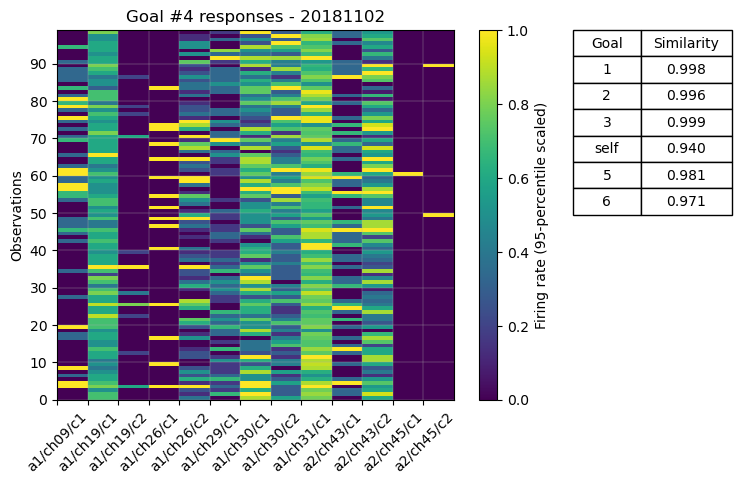

In [56]:
# Try plotting responses for one goal (normalized)
goal = 3
goal_responses = normalized_responses_per_goal[goal]
goal_sim = goal_sims[goal]
cross_sim = cross_sims[goal]
disp_table = list()
for num, score in enumerate(cross_sim):
    if num == goal:
        disp_table.append(['self', f'{goal_sim:.3f}'])
    else:
        disp_table.append([f'{num+1}', f'{score:.3f}'])

plt.figure()
plt.title(f'Goal #{goal+1} responses - {day_dir}')
pcm = plt.pcolormesh(goal_responses, cmap='viridis', vmin=0)
plt.grid(linewidth=0.25)
plt.xticks(np.arange(goal_responses.shape[1]), cell_labels, rotation=45)
plt.yticks(np.arange(0, goal_responses.shape[0]+1, 10))
plt.ylabel('Observations')
plt.colorbar(pcm, label='Firing rate (95-percentile scaled)')
plt.table(cellText=disp_table, colLabels=['Goal', 'Similarity'], cellLoc='center', colWidths=[0.15, 0.2], bbox=[1.3, 0.5, 0.4, 0.5])